In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf

# Folders
os.makedirs("../figures", exist_ok=True)
os.makedirs("../reports", exist_ok=True)

def save_current_figure(filename, dpi=300):
    path = f"../figures/{filename}"
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure -> {path}")

# Make plots readable for report
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14

/Users/shavarshmelikyan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/shavarshmelikyan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH = "../data/mdm2_data_files/big_table_with_weather_and_rain_with_geo_clusters_v2.csv"
df = pd.read_csv(PATH)

# Parse datetime
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", utc=True)

# Keep only rows needed for cyclists model
needed = ["cyc", "Dark", "cluster_geo", "temp_c", "wind_ms", "rain_mm", "hour", "dow", "month", "sensor_id", "datetime"]
df = df.dropna(subset=needed).copy()

# Ensure types
df["hour"] = df["hour"].astype(int)
df["dow"] = df["dow"].astype(int)
df["month"] = df["month"].astype(int)
df["cluster_geo"] = df["cluster_geo"].astype(int)

print("Shape after cleaning:", df.shape)
df.head()

Shape after cleaning: (378005, 19)


,ped,car,cyc,sensor_id,datetime,hour,date_only,dow,longitude,latitude,weekday,month,solar_altitude_deg,light_class,Dark,temp_c,wind_ms,rain_mm,cluster_geo
0,413,381,9,1,2024-01-01 00:00:00+00:00,0,2024-01-01,0,-2.591538,51.453815,0,1,-61.529806,darkness,1,7.8,15.0,0.0,2
1,402,489,10,1,2024-01-01 01:00:00+00:00,1,2024-01-01,0,-2.591538,51.453815,0,1,-60.225898,darkness,1,8.0,14.0,0.0,2
2,421,473,10,1,2024-01-01 02:00:00+00:00,2,2024-01-01,0,-2.591538,51.453815,0,1,-54.953852,darkness,1,8.0,16.0,0.0,2
3,370,419,4,1,2024-01-01 03:00:00+00:00,3,2024-01-01,0,-2.591538,51.453815,0,1,-47.266506,darkness,1,7.6,14.0,0.0,2
4,132,123,2,1,2024-01-01 04:00:00+00:00,4,2024-01-01,0,-2.591538,51.453815,0,1,-38.404055,darkness,1,7.4,12.0,0.0,2


In [3]:
formula = """
cyc ~ Dark
+ C(cluster_geo)
+ Dark:C(cluster_geo)
+ temp_c
+ wind_ms
+ rain_mm
+ C(hour)
+ C(dow)
+ C(month)
"""

model_cyc = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.NegativeBinomial()
).fit(cov_type="cluster", cov_kwds={"groups": df["sensor_id"]})

print(model_cyc.summary())

# Save full summary
with open("../reports/cyclists_nb_clustered_summary.txt", "w") as f:
    f.write(model_cyc.summary().as_text())

print("\nSaved -> ../reports/cyclists_nb_clustered_summary.txt")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cyc   No. Observations:               378005
Model:                            GLM   Df Residuals:                   377956
Model Family:        NegativeBinomial   Df Model:                           48
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3581e+06
Date:                Thu, 19 Feb 2026   Deviance:                   7.1113e+05
Time:                        23:12:26   Pearson chi2:                 2.27e+06
No. Iterations:                    16   Pseudo R-squ. (CS):             0.5039
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [4]:
pearson_chi2 = model_cyc.pearson_chi2
df_resid = model_cyc.df_resid
dispersion = pearson_chi2 / df_resid

print("\n" + "="*70)
print("CYCLISTS DISPERSION CHECK")
print("="*70)
print(f"Pearson Chi2: {pearson_chi2:,.2f}")
print(f"Residual DoF: {df_resid:,.0f}")
print(f"Dispersion (Chi2/DoF): {dispersion:.3f}")
print("="*70)


CYCLISTS DISPERSION CHECK
Pearson Chi2: 2,271,717.04
Residual DoF: 377,956
Dispersion (Chi2/DoF): 6.011


In [5]:
params = model_cyc.params

def pct_change(beta):
    return (np.exp(beta) - 1) * 100

clusters = sorted(df["cluster_geo"].unique())

rows = []
base_dark = params.get("Dark", np.nan)

for c in clusters:
    if c == 0:
        beta = base_dark
    else:
        beta = base_dark + params.get(f"Dark:C(cluster_geo)[T.{c}]", 0.0)
    rows.append({"cluster_geo": c, "beta_dark": beta, "pct_change_dark": pct_change(beta)})

dark_table = pd.DataFrame(rows).sort_values("cluster_geo")
display(dark_table)

dark_table.to_csv("../reports/cyclists_darkness_effect_by_cluster_clustered.csv", index=False)
print("Saved -> ../reports/cyclists_darkness_effect_by_cluster_clustered.csv")

print("\n" + "="*90)
print("CYCLISTS: DARKNESS EFFECT BY CLUSTER (clustered SE model)")
print("="*90)
for _, r in dark_table.iterrows():
    print(f"Cluster {int(r['cluster_geo'])}: {r['pct_change_dark']:.2f}%")
print("="*90)

,cluster_geo,beta_dark,pct_change_dark
0,0,0.130982,13.994740
1,1,0.173235,18.914499
2,2,-0.798130,-54.982998


Saved -> ../reports/cyclists_darkness_effect_by_cluster_clustered.csv

CYCLISTS: DARKNESS EFFECT BY CLUSTER (clustered SE model)
Cluster 0: 13.99%
Cluster 1: 18.91%
Cluster 2: -54.98%


Saved figure -> ../figures/cyclists_darkness_effect_by_cluster_clustered.png


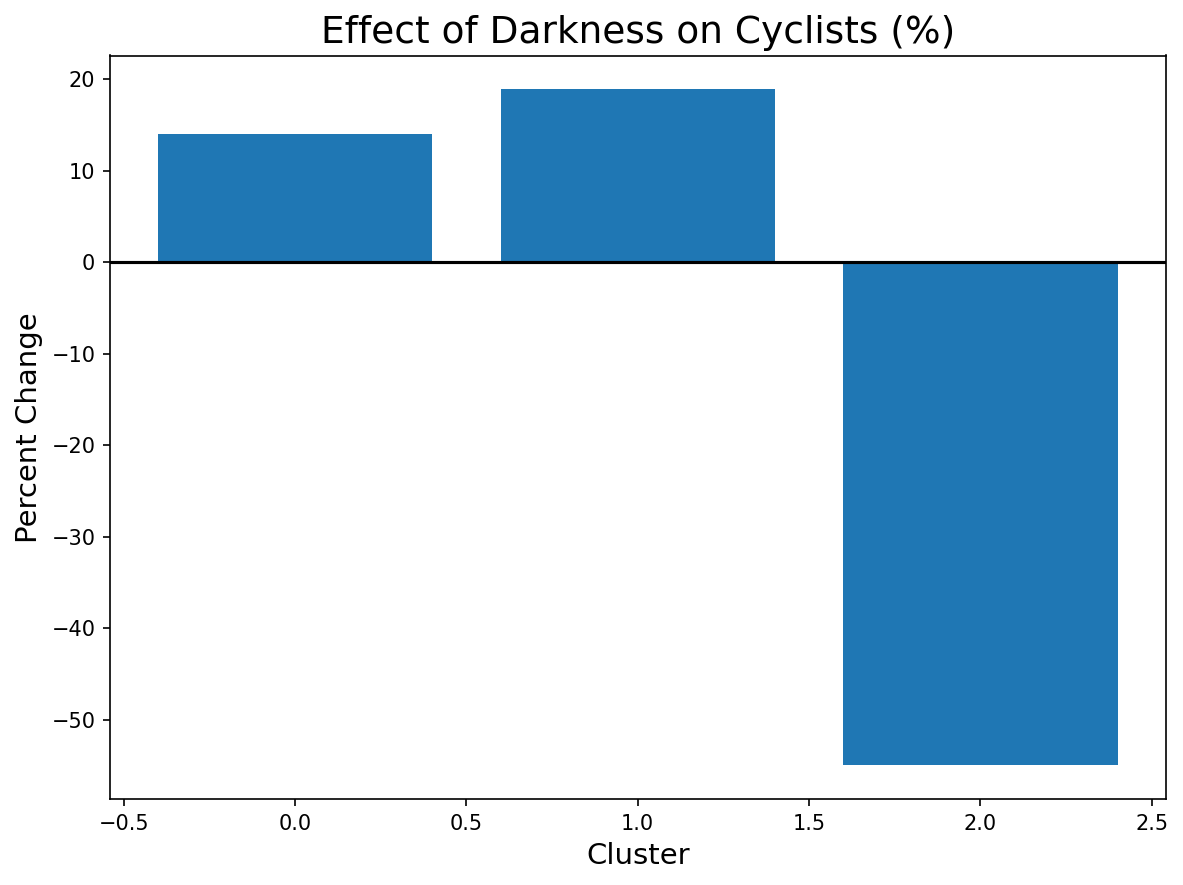

In [6]:
plt.figure(figsize=(8,6))
plt.bar(dark_table["cluster_geo"], dark_table["pct_change_dark"])
plt.axhline(0, color="black")
plt.title("Effect of Darkness on Cyclists (%)", fontsize=18)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Percent Change", fontsize=14)
plt.tight_layout()

save_current_figure("cyclists_darkness_effect_by_cluster_clustered.png")
plt.show()

Saved figure -> ../figures/cyclists_residuals_vs_fitted_clustered.png


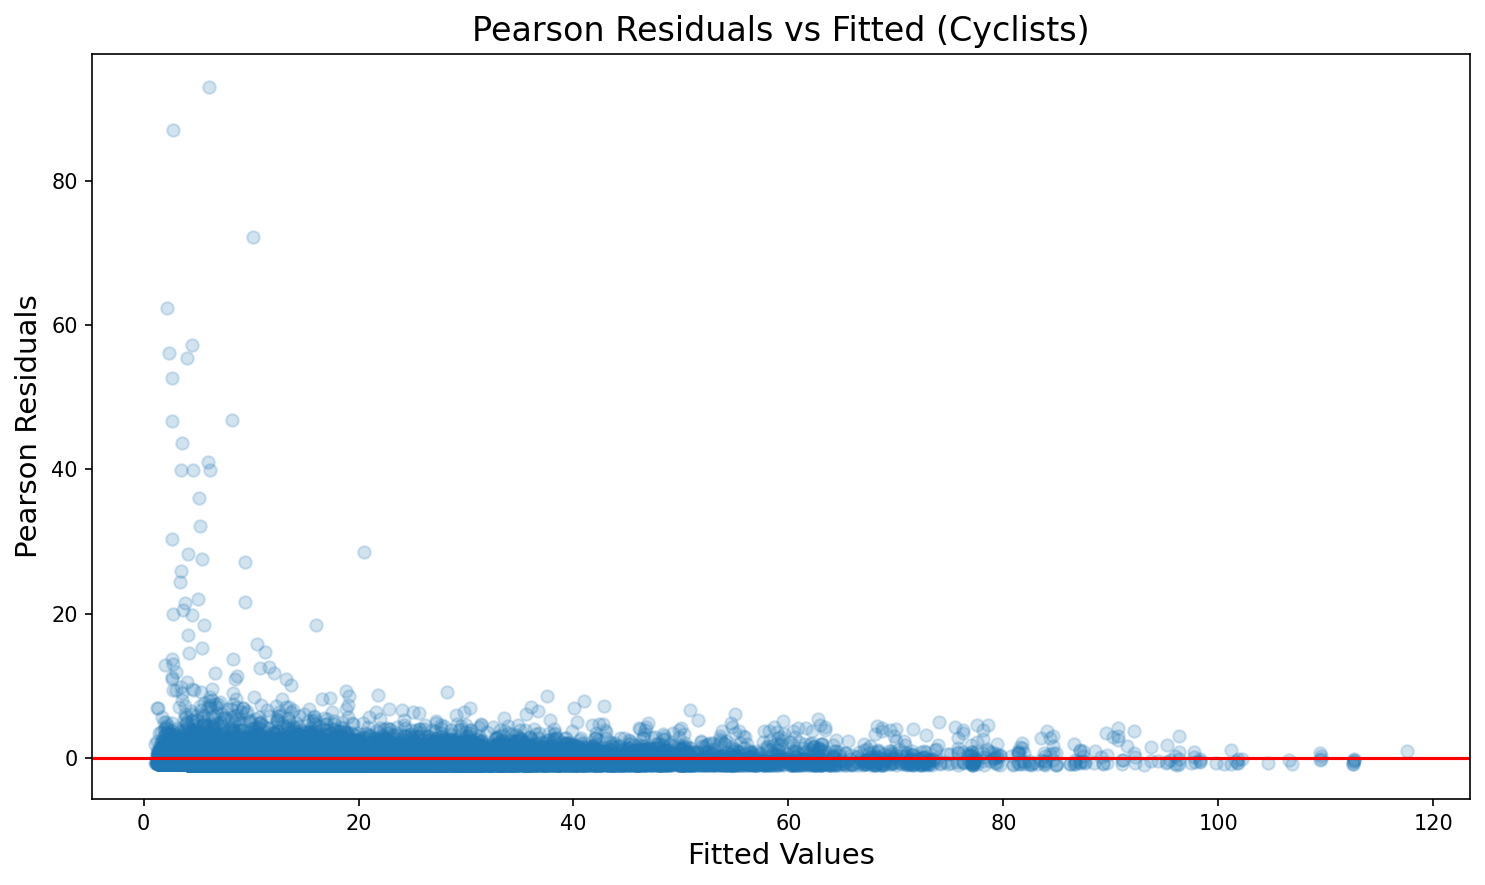

In [7]:
resid = model_cyc.resid_pearson
fitted = model_cyc.fittedvalues

sample_idx = resid.sample(20000, random_state=1).index

plt.figure(figsize=(10,6))
plt.scatter(fitted.loc[sample_idx], resid.loc[sample_idx], alpha=0.2)
plt.axhline(0, color="red")
plt.title("Pearson Residuals vs Fitted (Cyclists)", fontsize=16)
plt.xlabel("Fitted Values")
plt.ylabel("Pearson Residuals")
plt.tight_layout()

save_current_figure("cyclists_residuals_vs_fitted_clustered.png")
plt.show()

Saved figure -> ../figures/cyclists_acf_sensor_example.png


<Figure size 1500x900 with 0 Axes>

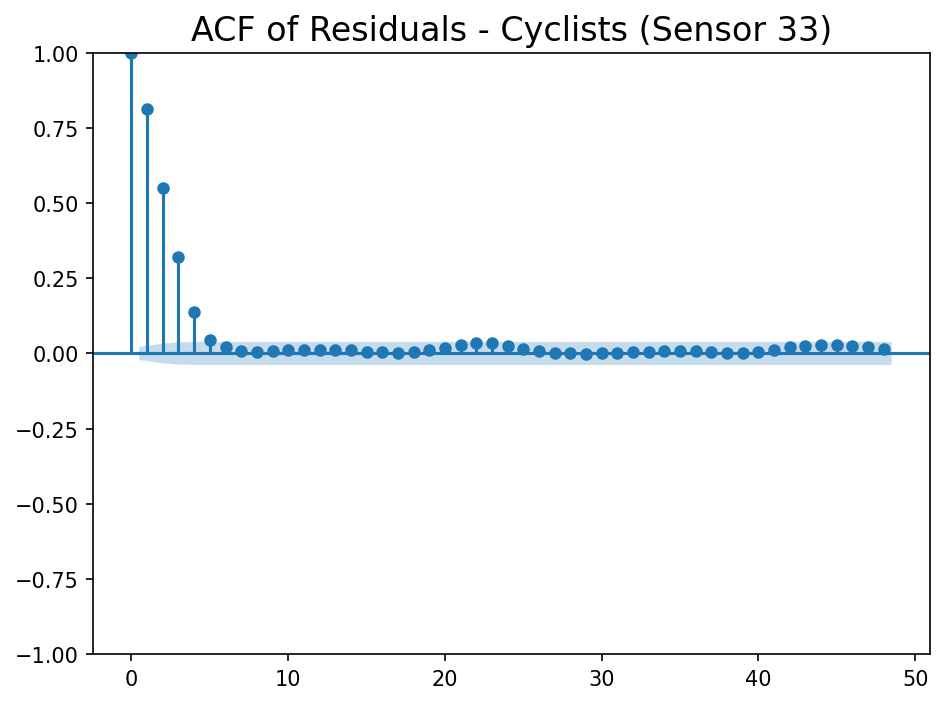

Sensor used for ACF: 33 | n = 8219


In [8]:
# pick a sensor with many observations (more stable ACF)
sensor_counts = df["sensor_id"].value_counts()
sensor_example = sensor_counts.index[0]

df_sensor = df[df["sensor_id"] == sensor_example].sort_values("datetime")
resid_sensor = model_cyc.resid_pearson[df_sensor.index]

plt.figure(figsize=(10,6))
plot_acf(resid_sensor, lags=48)
plt.title(f"ACF of Residuals - Cyclists (Sensor {sensor_example})", fontsize=16)
plt.tight_layout()

save_current_figure("cyclists_acf_sensor_example.png")
plt.show()

print("Sensor used for ACF:", sensor_example, "| n =", len(df_sensor))

In [9]:
#  Print the exact coefficients used for the darkness effect
params = model_cyc.params

print("\n" + "="*90)
print("COEFFICIENTS USED FOR DARKNESS EFFECTS")
print("="*90)

print("Dark (baseline cluster 0):", params.get("Dark", np.nan))

for c in sorted(df["cluster_geo"].unique()):
    if c == 0:
        continue
    key = f"Dark:C(cluster_geo)[T.{c}]"
    print(key + ":", params.get(key, 0.0))

print("="*90)

#  Recompute effects exactly (cluster-by-cluster)
def pct(beta):
    return (np.exp(beta) - 1) * 100

clusters = sorted(df["cluster_geo"].unique())

rows = []
for c in clusters:
    if c == 0:
        beta = params["Dark"]
    else:
        beta = params["Dark"] + params.get(f"Dark:C(cluster_geo)[T.{c}]", 0.0)
    rows.append({"cluster_geo": c, "beta_dark": beta, "pct_change_dark": pct(beta)})

dark_table_check = pd.DataFrame(rows).sort_values("cluster_geo")

print("\n" + "="*90)
print("RECOMPUTED DARKNESS EFFECTS (CYCLISTS)")
print("="*90)
for _, r in dark_table_check.iterrows():
    print(f"Cluster {int(r['cluster_geo'])}: beta={r['beta_dark']:.4f}  ->  {r['pct_change_dark']:.2f}%")
print("="*90)

display(dark_table_check)


COEFFICIENTS USED FOR DARKNESS EFFECTS
Dark (baseline cluster 0): 0.13098212507331766
Dark:C(cluster_geo)[T.1]: 0.04225243054350615
Dark:C(cluster_geo)[T.2]: -0.9291120691357825

RECOMPUTED DARKNESS EFFECTS (CYCLISTS)
Cluster 0: beta=0.1310  ->  13.99%
Cluster 1: beta=0.1732  ->  18.91%
Cluster 2: beta=-0.7981  ->  -54.98%


,cluster_geo,beta_dark,pct_change_dark
0,0,0.130982,13.994740
1,1,0.173235,18.914499
2,2,-0.798130,-54.982998



RAW CHECK: MEAN CYCLISTS IN DARK VS DAYLIGHT


,Daylight_mean,Dark_mean,raw_pct_change
cluster_geo,,,
0,18.128774,8.159491,-54.991492
1,23.326383,11.501216,-50.694388
2,40.687381,9.764595,-76.000926


Saved figure -> ../figures/cyclists_raw_pct_change_dark_vs_daylight.png


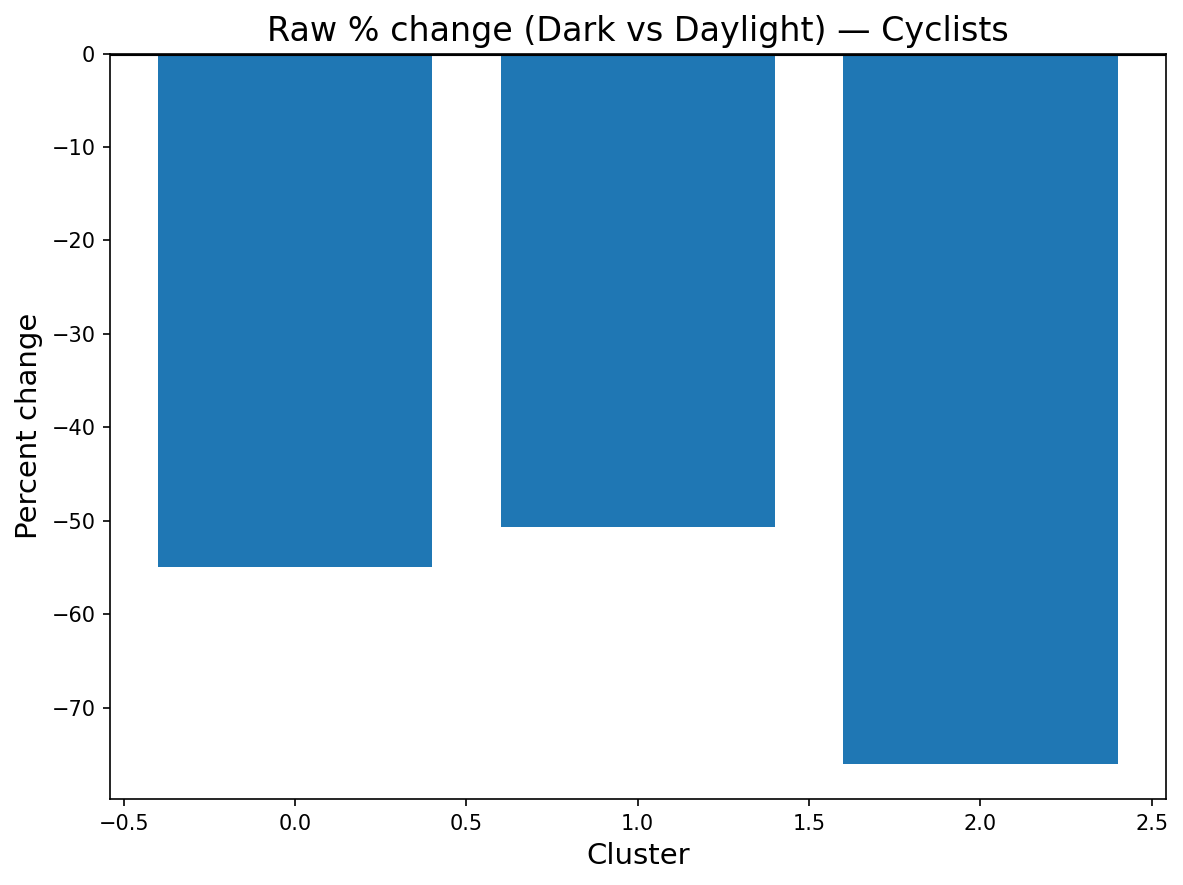

In [10]:
tmp = df.copy()

# crude means by cluster and Dark
raw_means = (tmp.groupby(["cluster_geo", "Dark"])["cyc"]
             .mean()
             .reset_index()
             .pivot(index="cluster_geo", columns="Dark", values="cyc"))

raw_means.columns = ["Daylight_mean" if c == 0 else "Dark_mean" for c in raw_means.columns]
raw_means["raw_pct_change"] = (raw_means["Dark_mean"] / raw_means["Daylight_mean"] - 1) * 100

print("\n" + "="*90)
print("RAW CHECK: MEAN CYCLISTS IN DARK VS DAYLIGHT")
print("="*90)
display(raw_means)

# optional bar plot
plt.figure(figsize=(8,6))
plt.bar(raw_means.index.astype(int), raw_means["raw_pct_change"])
plt.axhline(0, color="black")
plt.title("Raw % change (Dark vs Daylight) — Cyclists", fontsize=16)
plt.xlabel("Cluster")
plt.ylabel("Percent change")
plt.tight_layout()
save_current_figure("cyclists_raw_pct_change_dark_vs_daylight.png")
plt.show()

In [11]:
df_commute = df[df["hour"].isin([7,8,9,16,17,18,19])].copy()

model_cyc_commute = smf.glm(
    formula=formula,
    data=df_commute,
    family=sm.families.NegativeBinomial()
).fit(cov_type="cluster", cov_kwds={"groups": df_commute["sensor_id"]})

print(model_cyc_commute.summary())

# compute effects again
params2 = model_cyc_commute.params
rows = []
for c in sorted(df_commute["cluster_geo"].unique()):
    if c == 0:
        beta = params2.get("Dark", np.nan)
    else:
        beta = params2.get("Dark", np.nan) + params2.get(f"Dark:C(cluster_geo)[T.{c}]", 0.0)
    rows.append({"cluster_geo": c,
                 "beta_dark_commute": beta,
                 "pct_change_dark_commute": (np.exp(beta)-1)*100})

dark_commute = pd.DataFrame(rows).sort_values("cluster_geo")
print("\nCOMMUTE-HOURS DARKNESS EFFECTS (CYCLISTS)")
display(dark_commute)

dark_commute.to_csv("../reports/cyclists_darkness_effect_commute_hours.csv", index=False)
print("Saved -> ../reports/cyclists_darkness_effect_commute_hours.csv")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cyc   No. Observations:               105320
Model:                            GLM   Df Residuals:                   105288
Model Family:        NegativeBinomial   Df Model:                           31
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.5362e+05
Date:                Thu, 19 Feb 2026   Deviance:                   1.8444e+05
Time:                        23:17:35   Pearson chi2:                 1.28e+05
No. Iterations:                    17   Pseudo R-squ. (CS):             0.3315
Covariance Type:              cluster                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

,cluster_geo,beta_dark_commute,pct_change_dark_commute
0,0,-0.123558,-11.622989
1,1,0.160212,17.376005
2,2,-0.245572,-21.774288


Saved -> ../reports/cyclists_darkness_effect_commute_hours.csv



NEGATIVE BINOMIAL DISPERSION CHECK
Pearson Chi2: 2,271,717.04
Residual DF : 377956
Dispersion  : 6.011


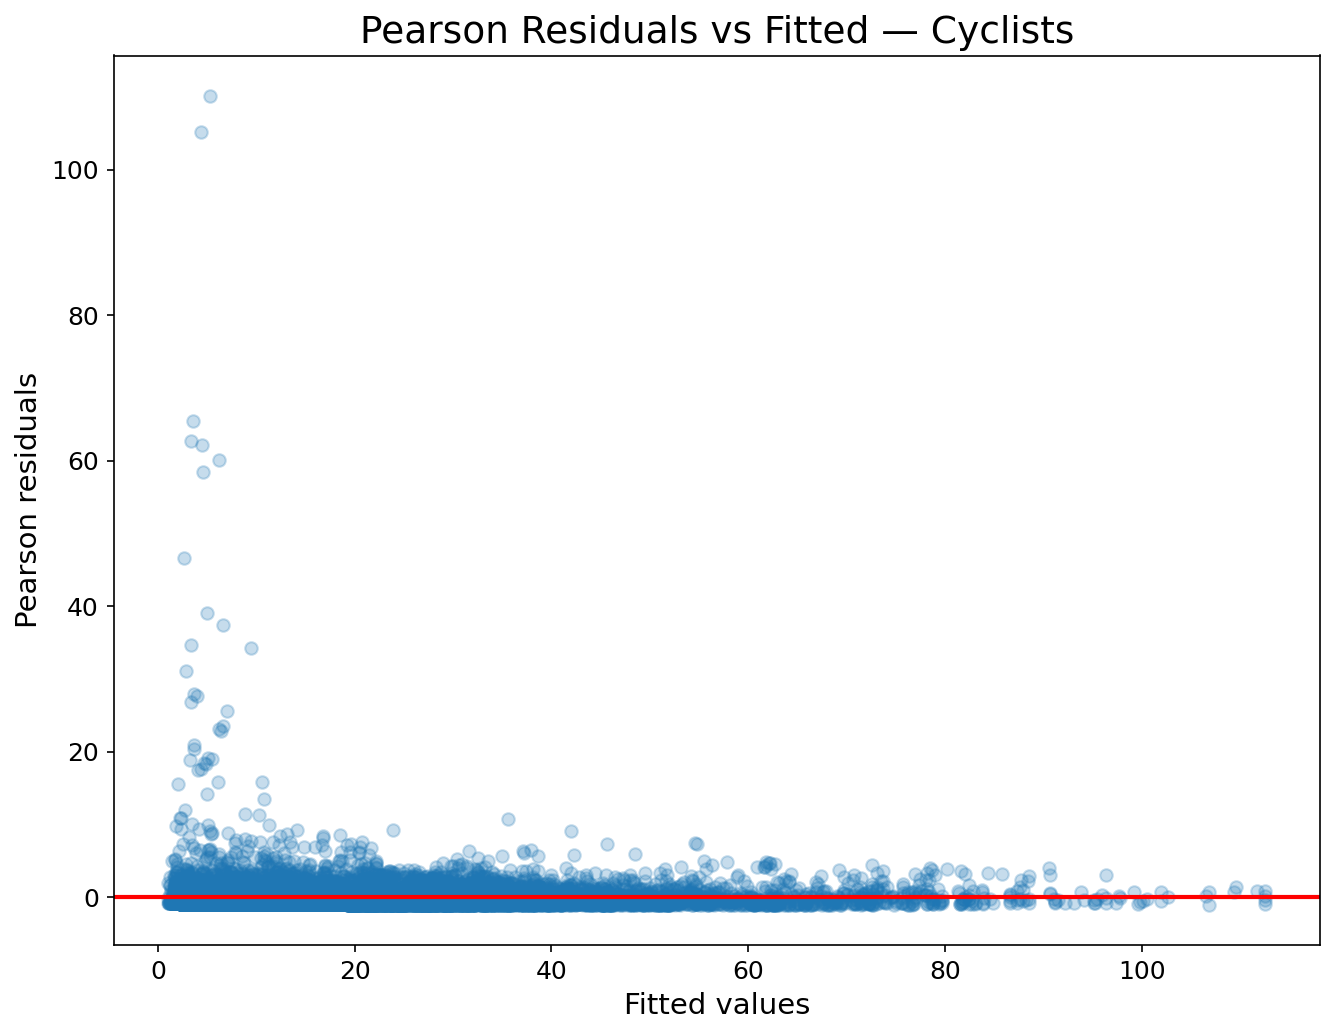

<Figure size 1350x1050 with 0 Axes>

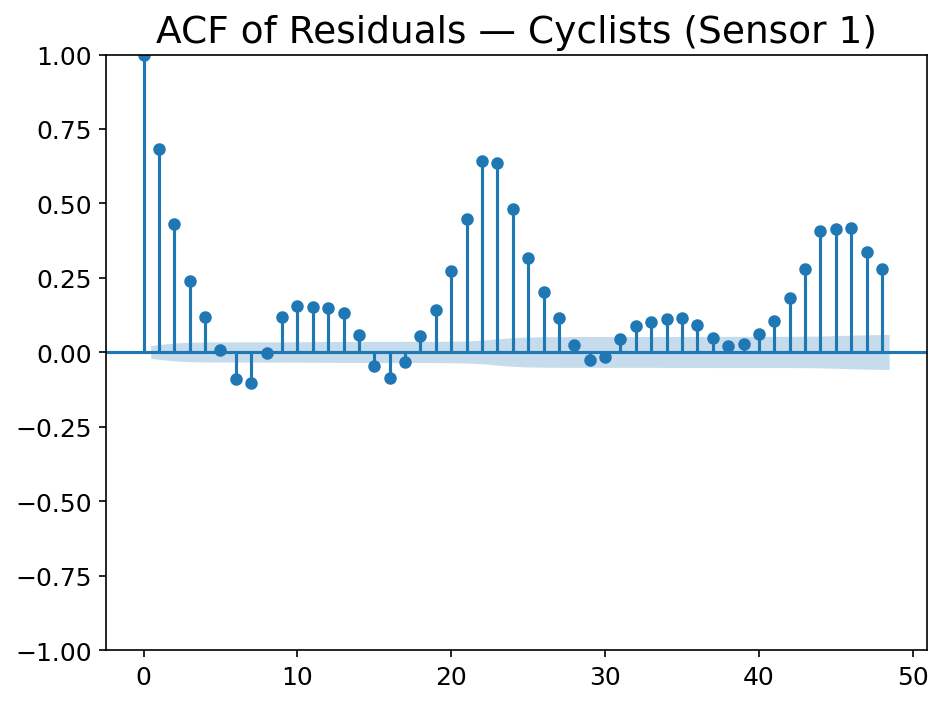

Saved improved diagnostic figures.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# ============================================================
# Dispersion statistic
# ============================================================

dispersion = model_cyc.pearson_chi2 / model_cyc.df_resid

print("\n" + "="*80)
print("NEGATIVE BINOMIAL DISPERSION CHECK")
print("="*80)
print(f"Pearson Chi2: {model_cyc.pearson_chi2:,.2f}")
print(f"Residual DF : {model_cyc.df_resid}")
print(f"Dispersion  : {dispersion:.3f}")
print("="*80)

# ============================================================
# Improved Residuals vs Fitted (sampled)
# ============================================================

fitted = model_cyc.fittedvalues
resid = model_cyc.resid_pearson

# sample for clarity
sample_idx = np.random.choice(len(fitted), size=15000, replace=False)

plt.figure(figsize=(9,7))
plt.scatter(fitted.iloc[sample_idx],
            resid.iloc[sample_idx],
            alpha=0.25)

plt.axhline(0, color="red", linewidth=2)
plt.title("Pearson Residuals vs Fitted — Cyclists", fontsize=18)
plt.xlabel("Fitted values", fontsize=14)
plt.ylabel("Pearson residuals", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("../figures/residuals_vs_fitted_cyclists_clean.png", dpi=300)
plt.show()

# ============================================================
# ACF — single sensor (clean version)
# ============================================================

sensor_example = df["sensor_id"].iloc[0]
resid_sensor = resid[df["sensor_id"] == sensor_example]

plt.figure(figsize=(9,7))
plot_acf(resid_sensor, lags=48)
plt.title(f"ACF of Residuals — Cyclists (Sensor {sensor_example})", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("../figures/acf_residuals_cyclists_clean.png", dpi=300)
plt.show()

print("Saved improved diagnostic figures.")